In [8]:
cd /home/kvothe/repo/dbt-metadata-utils/

/home/kvothe/repo/dbt-metadata-utils


In [9]:
%reload_ext autoreload
import json
from collections import deque
from typing import List, Dict, Tuple

from moz_sql_parser import parse #, ParseException
import networkx as nx
from dbt_metadata_utils.column_level import LineagePoint, find_col, slice_ctes, process_lineage_point, draw_graph, draw_multi_graph

In [23]:
model_name = "idf_entities"
query = parse("""
with scores_entities as (
    select
        score_type,
        score_id,
        score_name
    from "onefootball"."analytics"."stg_scores__entities"
),
articles as (
    select
        language_code,
        article_id,
        publish_time,
        title
    from
        "onefootball"."analytics_datasets"."train_set_tagging"
),
per_language_count as (
    select
        language_code,
        count(article_id) as per_language_count
    from articles
    group by 1
),
article_entities_counts as (
    select
        language as language_code,
        score_type,
        score_id,
        count(feed_item_id) as per_entity_count
    from "onefootball"."analytics"."stg_cms__feed_item_streams" as fis
    join articles on fis.feed_item_id = articles.article_id
    where
        score_type in ('team', 'competition', 'player')
    group by 1, 2, 3
)
select
    language_code,
    score_type,
    score_id,
    score_name,
    per_language_count,
    per_entity_count,
    log((1 + per_language_count) / (1 + per_entity_count)) + 1 as idf
from article_entities_counts
join per_language_count using (language_code)
join scores_entities using (score_type, score_id)
""")

In [3]:
#pprint(query['select'])
col_of_interest = 'idf'
m_cols, query = find_col(query, col_of_interest)
print('='*31)
print('>match cols')
print(m_cols)
print('>query')
print(query)
print('root')
root = LineagePoint(m_cols, query, model_name)
print('-'*31)
print(root)
print('+'*31)
print('lineage')
process_lineage_point(root, query)


NameError: name 'find_col' is not defined

In [11]:
def get_fields(a, b):
    return f"{a.split('.')[-1]}-{b.split('.')[-1]}"

In [12]:
def get_model(name):
    l = name.split('.')
    return '.'.join(l[:-1])

In [13]:
from pprint import pprint

def get_path(col_of_interest, path_id=0):
    nodes: Dict[str, bool] = {}  # dict with bool value which is equal to whether we display the node or not
    edges: List[Tuple[str, str]] = []
        
    # initialise the deque https://docs.python.org/3/library/collections.html#collections.deque
    root = LineagePoint(*find_col(query, col_of_interest), model_name)
    nodes[str(root)] = True
    to_be_parsed = deque([root])

    while len(to_be_parsed):
        lp = to_be_parsed.popleft()
    #     print((str(lp), lp.x, lp.y, lp.display_name))
        
        new_lps: List[LineagePoint] = process_lineage_point(lp, query)
        if new_lps is None or isinstance(lp, list) or isinstance(lp, dict):
            nodes[str(lp)] = False
        else:
            to_be_parsed.extend(new_lps)
            for new_lp in new_lps:
                edges.append((str(new_lp), str(lp)))
                nodes[str(new_lp)] = True
    #return [(n1, n2) for n1, n2 in edges if nodes.get(n1) and nodes.get(n2)]
    return [(get_model(n1), get_model(n2), {'label': get_fields(n1,n2), 'path': path_id}) for n1, n2 in edges if nodes.get(n1) and nodes.get(n2)]


In [1]:
G = nx.DiGraph()
e = get_path('idf')
G.add_edges_from(e)
fig = draw_graph(G)

NameError: name 'nx' is not defined

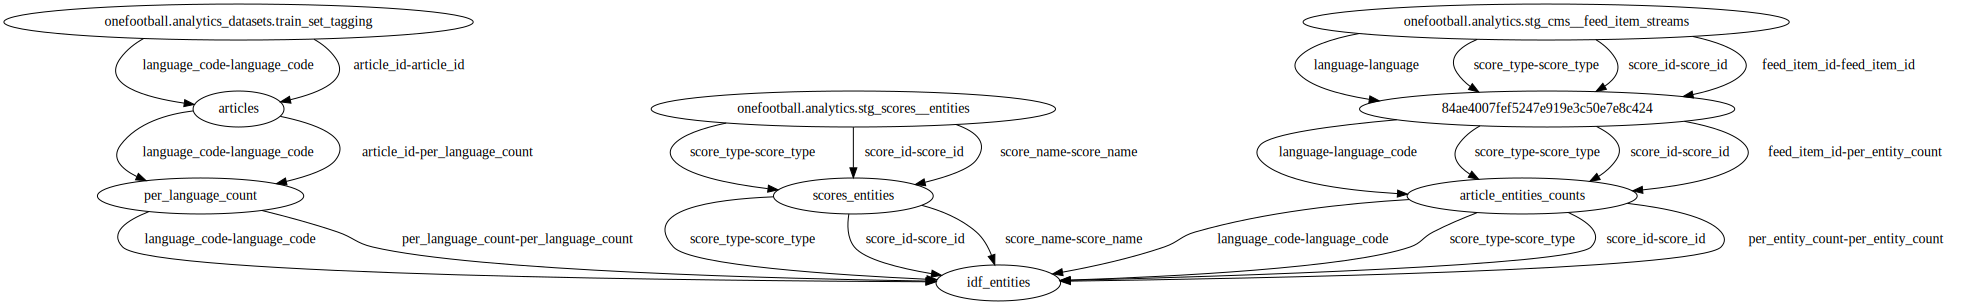

In [24]:
from IPython.display import SVG
cols = ['language_code','score_type','score_id','score_name','per_language_count','per_entity_count','idf']
G = nx.MultiDiGraph()
for i, col in enumerate(cols[:-1]):    
    edges = get_path(col, i)
    G.add_edges_from(edges)
graph = draw_multi_graph(G)
graph.write_png('output.png')
SVG(graph.create(prog='dot', format='svg')))

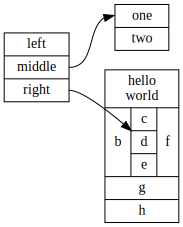

In [21]:
"""http://www.graphviz.org/pdf/dotguide.pdf, Figure 12"""

import graphviz

s = graphviz.Digraph('structs', filename='structs_revisited.gv',
                     node_attr={'shape': 'record'})

s.node('struct1', '<f0> left|<f1> middle|<f2> right')
s.node('struct2', '<f0> one|<f1> two')
s.node('struct3', r'hello\nworld |{ b |{c|<here> d|e}| f}| g | h')

s.edges([('struct1:f1', 'struct2:f0'), ('struct1:f2', 'struct3:here')])
s.graph_attr['rankdir'] = 'LR'
s

In [22]:
list(G.edges(data=True))[:2]

[('article_entities_counts',
  'idf_entities',
  {'label': 'language_code-language_code', 'path': 0}),
 ('article_entities_counts',
  'idf_entities',
  {'label': 'score_type-score_type', 'path': 1})]

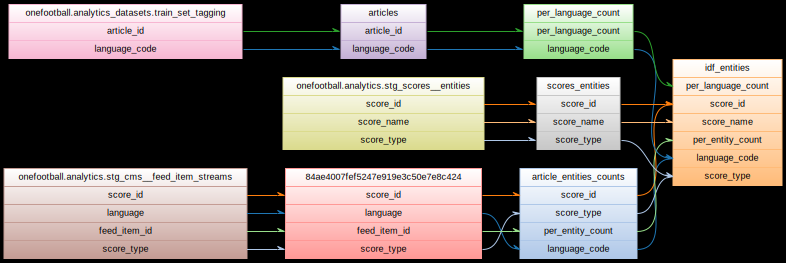

In [25]:
from palettable.tableau import TableauLight_10, Tableau_20
import graphviz
s = graphviz.Digraph(name='column-base lineage', 
                     filename='structs_revisited.gv',
                     graph_attr={'fontname': 'Sans-Serif', 'fontsize':'8'},
                     node_attr={'shape': 'record', 'style': 'filled', 'gradientangle':'90',
                                'fontname': 'Helvetica', 'fontsize':'9'},
                     edge_attr={'arrowhead':'halfopen', 'arrowsize':'0.7'})
s.attr(bgcolor='black')
d = dict()

for i, (a,b,e) in enumerate(G.edges(data=True)):
    x,y = e['label'].split('-')
    path_id = e['path']
    #print(e['label'],x,y)
    if a in d:           
        d[a].add(x)
    else:
        d[a]=set([x])
    if b in d:
        d[b].add(y)
    else:
        d[b]=set([y])
    s.edge(f'{a}:{a}.{x}', f'{b}:{b}.{y}', color=Tableau_20.hex_colors[path_id%20])

for i,(k,v) in enumerate(d.items()):    
    start_color = TableauLight_10.hex_colors[i%20]
    color = f'{start_color}:white'
    s.node(k, k+'|'+'|'.join([f'<{k}.{field}> {field}' for field in v]), color=color)

s.graph_attr['rankdir'] = 'LR'
s

